In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sc_special
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [2]:
def cuckoo_search(n, m, fit_func, lower_boundary, upper_boundary, iter_num=100, pa=0.25, beta=1.5, step_size=0.1):
    nests = generate_nests(n, m, lower_boundary, upper_boundary)
    fitness = calc_fitness(fit_func, nests)

    best_nest_index = np.argmax(fitness)
    best_fitness = fitness[best_nest_index]
    best_nest = nests[best_nest_index].copy()

    for _ in range(iter_num):
        nests = update_nests(fit_func, lower_boundary, upper_boundary, nests, best_nest, fitness, step_size)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        fitness = calc_fitness(fit_func, nests)
        
        max_nest_index = np.argmax(fitness)
        max_fitness = fitness[max_nest_index]
        max_nest = nests[max_nest_index]

        if (max_fitness > best_fitness):
            best_nest = max_nest.copy()
            best_fitness = max_fitness

    return best_nest, best_fitness

In [3]:
def generate_nests(n, m, lower_boundary, upper_boundary):
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    nests = np.empty((n, m))

    for each_nest in range(n):
        nests[each_nest] = lower_boundary + np.random.rand(m) * (upper_boundary - lower_boundary)

    return nests

In [4]:
def update_nests(fit_func, lower_boundary, upper_boundary, nests, best_nest, fitness, step_coefficient):
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        step_size = step_coefficient * steps[each_nest] * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m)
        new_nests[each_nest] += step_size * step_direction
        # Updated section: limiting new nest locations with np.clip
        new_nests[each_nest] = np.clip(new_nests[each_nest], lower_boundary, upper_boundary)

    new_fitness = calc_fitness(fit_func, new_nests)
    nests[new_fitness > fitness] = new_nests[new_fitness > fitness]
    
    return nests

In [5]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):
        if np.random.rand() < pa:
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # Updated section: limiting new nest locations with np.clip
            nests[each_nest] = np.clip(nests[each_nest], lower_boundary, upper_boundary)
    
    return nests

In [6]:
def levy_flight(n, m, beta):
    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [7]:
def calc_fitness(fit_func, nests):
    n, m = nests.shape
    fitness = np.empty(n)

    for each_nest in range(n):
        fitness[each_nest] = fit_func(nests[each_nest])

    return fitness

In [51]:
#08
def fit_func(nest):
    A, l_pos, epsilon_f_pos, l_neg, epsilon_f_neg = nest
    df_ex = pd.read_csv('data/data_ocv_ex.csv')
    df_sim = pd.read_csv('data/data_ocv_sim_ex.csv')

    v_t = df_ex['Voltage[V]']
    v_hat_t = df_sim['Voltage[V]']
    
    FF_V = mean_squared_error(v_t, v_hat_t)

    F = 96485.33212
    theta_0_pos = 0.915
    theta_0_neg = 0.008
    theta_100_pos = 0.254
    theta_100_neg = 0.855
    c_s_pos_max = 63104.0
    c_s_neg_max = 33133.0
    FF_C = np.abs((A * l_pos * epsilon_f_pos * F * c_s_pos_max * (theta_0_pos - theta_100_pos) / 3600) - 
                  (A * l_neg * epsilon_f_neg * F * c_s_neg_max * (theta_100_neg - theta_0_neg) / 3600))
    
    # Update section: normalise FF_V and FF_C and check that the denominator is zero
    if np.max(v_t) != np.min(v_t):
        FF_V_norm = (FF_V - np.min(v_t)) / (np.max(v_t) - np.min(v_t))
    else:
        FF_V_norm = 0

    if np.max(FF_C) != np.min(FF_C):
        FF_C_norm = (FF_C - np.min(FF_C)) / (np.max(FF_C) - np.min(FF_C))
    else:
        FF_C_norm = 0
    
    w_Vn = 0
    w_c = 1 - w_Vn
    FF_M = w_Vn * FF_V_norm + w_c * FF_C_norm
    
    return FF_M

In [52]:
if __name__ == '__main__':
    lower_bounds = [0.378, 35, 0.35, 35, 0.4]
    upper_bounds = [0.395, 79, 0.5, 79, 0.5,]

    best_nest, best_fitness = cuckoo_search(50, 5, fit_func, lower_bounds, upper_bounds, step_size=0.4)

    print('Max fitness: %.5f, Best nest position: (A: %.5f, l_pos: %.5f, epsilon_f_pos: %.5f,l_neg: %.5f, epsilon_f_neg: %.5f)' 
          % (best_fitness, best_nest[0], best_nest[1], best_nest[2], best_nest[3], best_nest[4]))

Max fitness: 0.00000, Best nest position: (A: 0.39200, l_pos: 42.91360, epsilon_f_pos: 0.48828,l_neg: 36.46066, epsilon_f_neg: 0.44452)


In [53]:
l_pos = best_nest[1] * 1e-6
epsilon_f_pos = best_nest[2]
l_neg = best_nest[3] * 1e-6
epsilon_f_neg = best_nest[4]

In [54]:
# 加载数据
df_ex = pd.read_csv('data/data_ocv_ex.csv')
df_sim = pd.read_csv('data/data_ocv_sim_ex.csv')

v_t = df_ex['Voltage[V]']
v_hat_t = df_sim['Voltage[V]']

# 计算优化前后的MSE
initial_mse = mean_squared_error(v_t, v_hat_t)
print(f'MSE: {initial_mse}')

MSE: 0.0012508164464828703


In [55]:
# Create a simple DFN model
model = pybamm.lithium_ion.SPM()
# create experiment
experiment = pybamm.Experiment(
    ["Rest for 901 s",
        (
            "Discharge at 0.96 A for 147 s",
            "Rest for 361 s",
        ) * 10,
     "Discharge at 0.96 A for 134 s"
    ]
    
)
# Setting the current function）
param = pybamm.ParameterValues("OKane2022")
param["Positive electrode thickness [m]"] = l_pos
param["Positive electrode active material volume fraction"] = epsilon_f_pos
param["Negative electrode thickness [m]"] = l_neg
param["Negative electrode active material volume fraction"] = epsilon_f_neg

# Creating Simulation Objects
solver = pybamm.CasadiSolver(mode="safe")
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)

# Running simulations with time ranges consistent with data
solution = simulation.solve(calc_esoh=False)  
# Getting results
time_opt = solution["Time [s]"].entries
# current = solution["Current [A]"].entries
voltage_opt = solution["Terminal voltage [V]"].entries

In [13]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_1 = interp_function(new_time)

In [24]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_08 = interp_function(new_time)

In [32]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_02 = interp_function(new_time)

In [40]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_002 = interp_function(new_time)

In [48]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_0002 = interp_function(new_time)

In [56]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_00 = interp_function(new_time)

In [14]:
df_ex_6115 = df_ex.head(6115)
votage_ex = df_ex_6115['Voltage[V]']

In [16]:
df_sim_6115 = df_sim.head(6115)
voltage_sim = df_sim_6115['Voltage[V]']

In [17]:
# Calculating MSE
mse = mean_squared_error(votage_ex, voltage_sim)
print(f'MSE: {mse}')

MSE: 9.433915857337991e-05


In [15]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_1)
print(f'MSE: {mse}')

MSE: 0.0017973397963452742


In [25]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_08)
print(f'MSE: {mse}')

MSE: 0.003136743022311665


In [33]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_02)
print(f'MSE: {mse}')

MSE: 0.0007324649604076494


In [41]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_002)
print(f'MSE: {mse}')

MSE: 0.0031231464716300035


In [49]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_0002)
print(f'MSE: {mse}')

MSE: 0.0005419952159018762


In [57]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_00)
print(f'MSE: {mse}')

MSE: 0.0030719148694528142


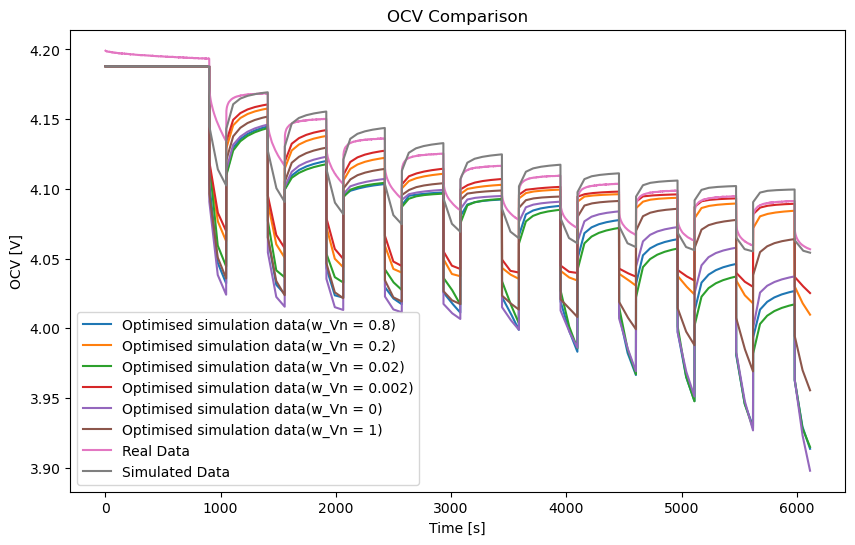

In [58]:
# Plotting comparisons
plt.figure(figsize=(10, 6))
# plt.plot(time_real, voltage_real, label='Real Data')
plt.plot(new_time, new_voltage_opt_08, label='Optimised simulation data(w_Vn = 0.8)')
plt.plot(new_time, new_voltage_opt_02, label='Optimised simulation data(w_Vn = 0.2)')
plt.plot(new_time, new_voltage_opt_002, label='Optimised simulation data(w_Vn = 0.02)')
plt.plot(new_time, new_voltage_opt_0002, label='Optimised simulation data(w_Vn = 0.002)')
plt.plot(new_time, new_voltage_opt_00, label='Optimised simulation data(w_Vn = 0)')
plt.plot(new_time, new_voltage_opt_1, label='Optimised simulation data(w_Vn = 1)')
plt.plot(new_time, votage_ex, label='Real Data')
plt.plot(new_time, voltage_sim, label='Simulated Data')
plt.xlabel('Time [s]')
plt.ylabel('OCV [V]')
plt.title('OCV Comparison')
plt.legend()
plt.show()